## Load DATA

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [3]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [4]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [5]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [6]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [7]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [8]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [9]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [10]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d9632d07d30>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d9632d07ac0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d9632d074f0>)],
                  verbose=True)

In [11]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [12]:
features_config_get = {}

In [13]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    # 'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [14]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-15 13:50:37,572: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-15 13:50:37,581: INFO: Initialisation des features
root 2024-11-15 13:50:37,583: INFO: Fetching dataset
root 2024-11-15 13:50:37,833: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:38,130: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:38,385: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:38,647: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:38,930: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:39,207: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:39,461: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:39,696: INFO: trafficfeatures's data already fetched for CHU Dijon
root 2024-11-15 13:50:39,942: INFO: Getting the da

            nb_emmergencies  nb_emmergencies%%J-1  nb_emmergencies%%J-2  \
date                                                                      
2019-01-01              202                 202.0                 202.0   
2019-01-02              198                 202.0                 202.0   
2019-01-03              186                 198.0                 202.0   
2019-01-04              186                 186.0                 198.0   
2019-01-05              204                 186.0                 186.0   
...                     ...                   ...                   ...   
2023-12-26              177                 187.0                 177.0   
2023-12-27              165                 177.0                 187.0   
2023-12-28              192                 165.0                 177.0   
2023-12-29              157                 192.0                 165.0   
2023-12-30              212                 157.0                 192.0   

            nb_emmergenc

root 2024-11-15 13:50:41,534: INFO: 46 features not encoded (same unit as target)


Dropped 92 constant columns from both sets: {'PM25_FR26094', 'NO2_FR26094', 'trend_épilepsie', 'NO2_FR26010', 'PM10_FR26010', 'PM10_FR26094'}
X shape: (1162, 1381), y shape: (1162, 1)
[ColumnTransformer] .... (1 of 4) Processing pipeline-1, total=   0.0s
[ColumnTransformer] .... (2 of 4) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (3 of 4) Processing pipeline-4, total=   0.0s
[ColumnTransformer] .... (4 of 4) Processing pipeline-5, total=   0.0s


In [15]:
df = arsTabularDataset.enc_data.copy(deep=True)

In [16]:
df

,trend_fracture%%mean_7J,trend_vertiges%%J-1,meteo_wspd%%J-4,trend_infection cutanée%%J-3,trend_vaccin%%mean_7J,trend_éruption cutanée%%J-5,trend_saignements%%J-1,trend_AVC,trend_gastro-entérite%%J-5,meteo_prcp%%mean_31J,...,target_nb_emmergencies%%J+3%%mean_3J%%J-11,target_nb_emmergencies%%J+3%%mean_3J%%J-9,nb_accidents%%std_7J,target_nb_emmergencies%%J+3%%mean_3J%%J-8,nb_emmergencies%%J-7,target_nb_emmergencies%%J+3%%mean_3J%%std14J%%J-6,nb_emmergencies%%std_365J,nb_emmergencies%%std_7J,nb_accidents%%std_14J,nb_emmergencies%%std_31J
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.321367,-0.05067,-1.009526,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,189.666667,0.48795,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460
2019-01-04,-0.321367,-0.05067,-1.009526,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,189.666667,0.48795,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460
2019-01-05,-0.321367,-0.05067,-1.009526,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,189.666667,0.48795,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460
2019-01-06,-0.321367,-0.05067,1.090095,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,189.666667,0.48795,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460
2019-01-07,-0.321367,-0.05067,0.471456,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,189.666667,0.48795,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,-0.321367,-0.05067,-0.259662,-0.058133,-0.631995,-0.029348,-0.050664,-0.103495,-0.029348,1.056984,...,175.333333,168.333333,0.00000,168.666667,171.0,10.341572,18.901087,16.516947,0.000000,17.007525
2023-12-21,-0.321367,-0.05067,-1.234486,15.823747,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,1.103427,...,182.666667,168.666667,0.00000,166.000000,191.0,9.780372,18.892883,16.791438,0.000000,17.017006
2023-12-22,-0.321367,-0.05067,-1.253232,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,1.118908,...,168.333333,166.000000,0.00000,177.666667,164.0,9.481973,18.867387,16.237816,0.000000,16.470044


## Trend prediction

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Tuple

In [18]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False, offset=0):
    if labels == None and type(bins) == int:
        labels = [f'{i+offset}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+offset}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [19]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=True)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)

            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            print(y_pred)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=True)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Calendaire

In [20]:
df = df.drop(df.loc['2020-03':'2020-05'].index)

target = arsTabularDataset.targets_names[0]

# y = df[target]
y = arsTabularDataset.data[target]
y = y.drop(y.loc['2020-03':'2020-05'].index)
result = seasonal_decompose(y, model='additive', period=7)

#df = df0.copy()
df0 = arsTabularDataset.data.copy(deep=True)
df['target'] = result.resid.copy()
df.dropna(inplace=True)
df = categorize(df, 'target', bins=7, drop=True, offset=0)
df['target'] = df['target'].astype(int)


In [21]:
df0

,trend_fracture%%mean_7J,trend_vertiges%%J-1,meteo_wspd%%J-4,holidays%%J-2,trend_infection cutanée%%J-3,confinement1%%J-7,trend_vaccin%%mean_7J,trend_éruption cutanée%%J-5,trend_saignements%%J-1,trend_AVC,...,trend_mal de tête%%J-7,trend_saignements%%J-2,trend_noyade%%J-1,meteo_tavg%%J-7,trend_hopital%%J-6,trend_accident de voiture%%mean_7J,PM10_FR26005%%mean_7J,trend_vaccin%%J-2,trend_fièvre%%std_31J,nb_emmergencies%%std_31J
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,18.857143,0.0,0.0,18.612460
2019-01-04,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,17.714286,0.0,0.0,18.612460
2019-01-05,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.428571,0.0,0.0,18.612460
2019-01-06,0.0,0.0,17.4,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.571429,0.0,0.0,18.612460
2019-01-07,0.0,0.0,14.1,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.142857,0.0,0.0,18.612460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,0.0,0.0,10.2,False,0.0,False,1.285714,0.0,0.0,0.0,...,0.0,0.0,0.0,8.8,11.0,0.0,12.714286,0.0,0.0,17.007525
2023-12-21,0.0,0.0,5.0,False,75.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,7.4,18.0,0.0,13.428571,0.0,0.0,17.017006
2023-12-22,0.0,0.0,4.9,False,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.6,0.0,0.0,13.285714,0.0,0.0,16.470044


In [22]:
# dg0 = df0.copy()
# dg0['resid'] = result.resid
# dg0.drop('target', axis=1, inplace=True)
# dg0.rename({'resid': 'target'}, axis=1, inplace=True)
# dg0.dropna(inplace=True)
# dg0['target'] = dg0['target'].apply(lambda x: 1 if x > 0 else 0)

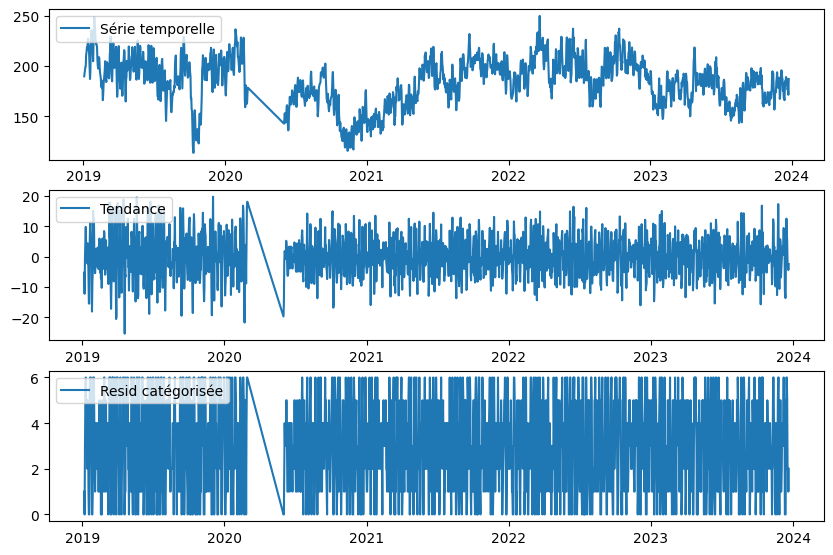

In [23]:
# Affichage des composantes
plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.plot(y, label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.resid, label='Tendance')
plt.legend(loc='upper left')


# print(df['target'])
ax3 = plt.subplot(413)  # Capture the Axes for the third subplot
plt.plot(df['target'], label='Resid catégorisée')
ax3.set_ylim(sorted(ax3.get_ylim()))  # Corrects the order of y-axis with 0 at the bottom
plt.legend(loc='upper left')

# plt.subplot(413)
# plt.plot(result.seasonal, label='Saisonnalité')
# plt.legend(loc='upper left')

# plt.subplot(414)
# plt.plot(result.resid, label='Résidu')
# plt.legend(loc='upper left')
# plt.tight_layout()
plt.show()

In [24]:
df

,trend_fracture%%mean_7J,trend_vertiges%%J-1,meteo_wspd%%J-4,trend_infection cutanée%%J-3,trend_vaccin%%mean_7J,trend_éruption cutanée%%J-5,trend_saignements%%J-1,trend_AVC,trend_gastro-entérite%%J-5,meteo_prcp%%mean_31J,...,target_nb_emmergencies%%J+3%%mean_3J%%J-9,nb_accidents%%std_7J,target_nb_emmergencies%%J+3%%mean_3J%%J-8,nb_emmergencies%%J-7,target_nb_emmergencies%%J+3%%mean_3J%%std14J%%J-6,nb_emmergencies%%std_365J,nb_emmergencies%%std_7J,nb_accidents%%std_14J,nb_emmergencies%%std_31J,target
date,,,,,,,,,,,,,,,,,,,,,
2019-01-06,-0.321367,-0.05067,1.090095,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,0.487950,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460,1
2019-01-07,-0.321367,-0.05067,0.471456,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,0.487950,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460,0
2019-01-08,-0.321367,-0.05067,-0.109689,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,0.487950,189.666667,202.0,12.225621,26.347167,8.629959,0.759555,18.612460,3
2019-01-09,-0.321367,-0.05067,-0.109689,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,0.534522,189.666667,198.0,12.225621,26.347167,7.745967,0.759555,18.612460,5
2019-01-10,-0.321367,-0.05067,0.002791,-0.058133,-0.725239,-0.029348,-0.050664,-0.103495,-0.029348,-0.642846,...,189.666667,0.534522,189.666667,186.0,12.225621,26.347167,8.202787,0.759555,18.612460,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17,-0.321367,-0.05067,0.321484,-0.058133,-0.518030,-0.029348,-0.050664,-0.103495,-0.029348,1.109619,...,187.000000,0.000000,175.333333,191.0,9.037198,19.070248,13.171036,0.000000,16.244768,5
2023-12-18,-0.321367,-0.05067,0.021538,-0.058133,-0.518030,-0.029348,-0.050664,-0.103495,-0.029348,1.109619,...,175.333333,0.000000,182.666667,194.0,9.718630,19.084927,19.183326,0.000000,17.261431,2
2023-12-19,-0.321367,-0.05067,-1.290726,-0.058133,-0.518030,-0.029348,-0.050664,-0.103495,-0.029348,1.063176,...,182.666667,0.000000,168.333333,199.0,10.336612,18.971993,18.783225,0.000000,17.153074,2


[3. 3. 3. 3. 3. 3. 6. 3. 6. 6. 2. 2. 3. 0. 3. 3. 1. 1. 6. 0. 1. 6. 6. 6.
 6. 6. 6. 6. 3. 1. 1. 2. 1. 5. 1. 1. 1. 5. 5. 5. 5. 3. 2. 5. 1. 1. 5. 1.
 5. 1. 5. 5. 5. 1. 1. 1. 5. 6. 3. 0. 6. 3. 6. 3. 2. 2. 2. 2. 3. 2. 2. 2.
 0. 3. 3. 2. 6. 3. 5. 5. 5. 5. 5. 5. 6. 2. 2. 5. 3. 3. 3. 3. 3. 3. 3. 3.
 1. 1. 5. 1. 0. 3. 1. 3. 3. 3. 5. 1. 0. 1. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3.
 3. 1. 6. 3. 1. 3. 3. 3. 3. 6. 6. 3. 6. 6. 3. 3. 3. 3. 3. 1. 3. 3. 3. 1.
 1. 1. 1. 1. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 4. 1. 3. 6. 6. 3. 3. 3. 3. 3.
 6. 3. 3. 3. 4. 3. 1. 1. 1. 4. 3. 1. 4. 1. 4. 4. 4. 1. 1. 4. 4. 6. 6. 4.
 1. 1. 2. 6. 2. 3. 4. 0. 4. 4. 3. 5. 3. 3. 3. 3. 4. 3. 1. 4. 4. 0. 1. 3.
 3. 1. 1. 3. 1. 1. 3. 1. 1. 3. 3. 3. 1. 1. 1. 1. 3. 3. 1. 1. 6. 6. 5. 6.
 3. 1. 3. 3. 6. 6. 3. 3. 3. 3. 3. 6. 6. 6. 6. 3. 1. 3. 6. 6. 3. 3. 2. 3.
 1. 3. 3. 3. 6. 6. 6. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 5. 3. 3. 3. 3. 2. 6.
 3. 3. 3. 3. 0. 3. 6. 3. 3. 0. 4. 4. 3. 1. 3. 3. 3. 4. 1. 3. 3. 6. 5. 0.
 5. 3. 2. 1. 3. 0. 3. 0. 1. 6. 0. 0. 0. 3. 3. 4. 3.

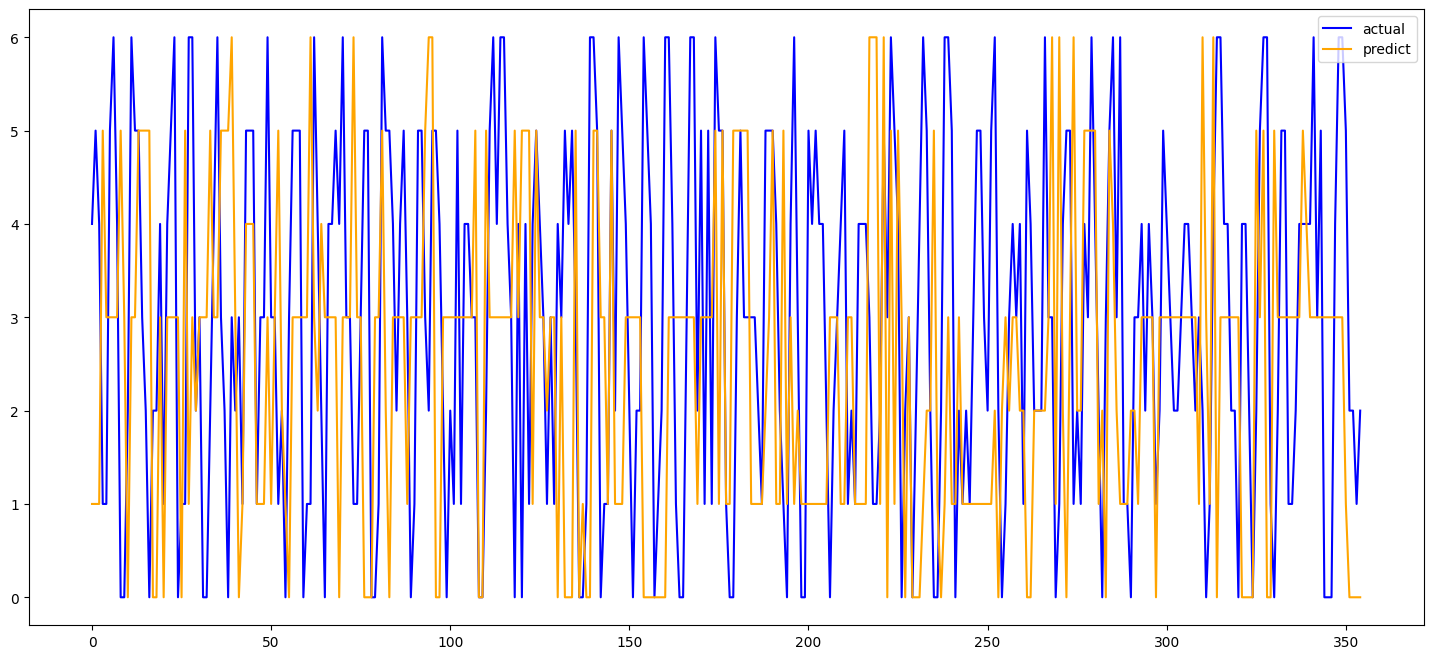

15.21%,1%
15.21%,2%
15.21%,3%
15.21%,4%
15.21%,5%
15.21%,6%
15.21%,7%
15.21%,8%
15.21%,9%
15.21%,10%
15.21%,11%
   - MAE : 2.18 (2.08 sur 2023)
   - MSE : 7.40 (6.68 sur 2023)
[6. 6. 6. 6. 6. 5. 6. 3. 0. 6. 2. 0. 0. 0. 3. 0. 0. 0. 6. 6. 6. 6. 6. 6.
 6. 6. 4. 0. 3. 0. 1. 2. 1. 3. 6. 6. 5. 5. 1. 1. 5. 3. 6. 5. 6. 1. 1. 1.
 1. 5. 5. 5. 1. 6. 6. 6. 5. 6. 6. 4. 1. 3. 6. 3. 2. 6. 6. 1. 1. 0. 2. 0.
 1. 2. 3. 5. 0. 6. 3. 5. 5. 5. 0. 5. 2. 2. 2. 6. 5. 1. 1. 3. 5. 3. 3. 3.
 1. 1. 4. 4. 4. 4. 1. 4. 3. 4. 3. 3. 4. 4. 4. 4. 4. 4. 4. 2. 1. 2. 4. 4.
 4. 4. 4. 4. 1. 4. 3. 3. 4. 6. 1. 2. 6. 2. 2. 2. 2. 1. 3. 3. 1. 4. 1. 4.
 4. 4. 1. 4. 3. 1. 4. 4. 1. 3. 3. 4. 4. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 6. 1. 1. 4. 4. 4. 4. 4. 6. 4. 4. 4. 4. 4. 4. 4. 4. 1. 2.
 4. 2. 1. 4. 6. 2. 1. 4. 4. 4. 6. 6. 4. 4. 3. 3. 1. 1. 1. 4. 6. 3. 4. 3.
 6. 6. 1. 1. 1. 4. 5. 1. 1. 5. 2. 1. 1. 1. 6. 4. 6. 3. 1. 5. 5. 5. 6. 5.
 1. 0. 1. 1. 3. 6. 2. 2. 0. 1. 1. 6. 6. 1. 6. 1. 1. 1. 6. 6. 6. 2. 0. 1.
 1. 1. 1. 2. 2. 4. 2.

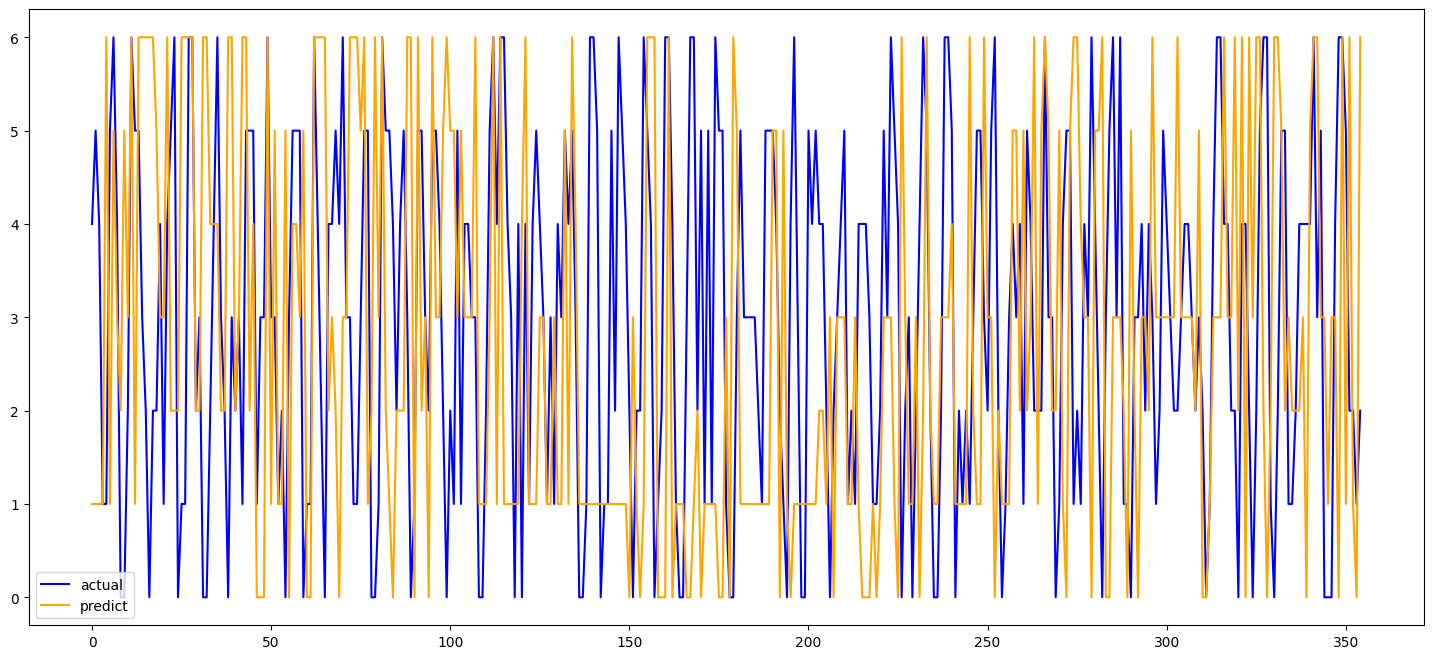

15.77%,1%
15.77%,2%
15.77%,3%
15.77%,4%
15.77%,5%
15.77%,6%
15.77%,7%
15.77%,8%
15.77%,9%
15.77%,10%
15.77%,11%
   - MAE : 2.17 (2.29 sur 2023)
   - MSE : 7.26 (8.24 sur 2023)
[3. 3. 2. 2. 3. 3. 3. 3. 2. 2. 2. 4. 3. 6. 3. 3. 5. 2. 3. 3. 5. 3. 5. 4.
 4. 4. 4. 4. 2. 5. 2. 4. 4. 2. 2. 3. 3. 5. 2. 2. 2. 2. 5. 5. 0. 0. 4. 5.
 3. 3. 5. 5. 1. 1. 1. 5. 3. 2. 3. 2. 1. 3. 6. 3. 3. 4. 0. 3. 3. 2. 2. 2.
 3. 0. 6. 6. 3. 3. 0. 2. 2. 3. 3. 6. 2. 0. 2. 2. 2. 2. 3. 3. 3. 2. 3. 3.
 3. 3. 4. 6. 1. 3. 1. 3. 3. 2. 5. 3. 3. 3. 3. 3. 3. 3. 1. 2. 1. 3. 1. 4.
 1. 1. 2. 2. 1. 3. 3. 3. 2. 1. 1. 1. 3. 6. 2. 3. 3. 1. 3. 0. 2. 1. 6. 4.
 1. 3. 1. 3. 3. 4. 4. 1. 4. 3. 3. 4. 4. 1. 4. 1. 3. 5. 3. 1. 2. 2. 5. 4.
 6. 4. 4. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 2. 2. 2. 2. 5. 5. 4. 1. 1. 4. 4. 4. 4. 2. 2. 5. 4. 6. 2.
 2. 0. 1. 5. 6. 2. 5. 5. 0. 2. 5. 5. 5. 2. 5. 5. 5. 6. 1. 5. 2. 2. 3. 2.
 3. 3. 3. 3. 6. 6. 2.

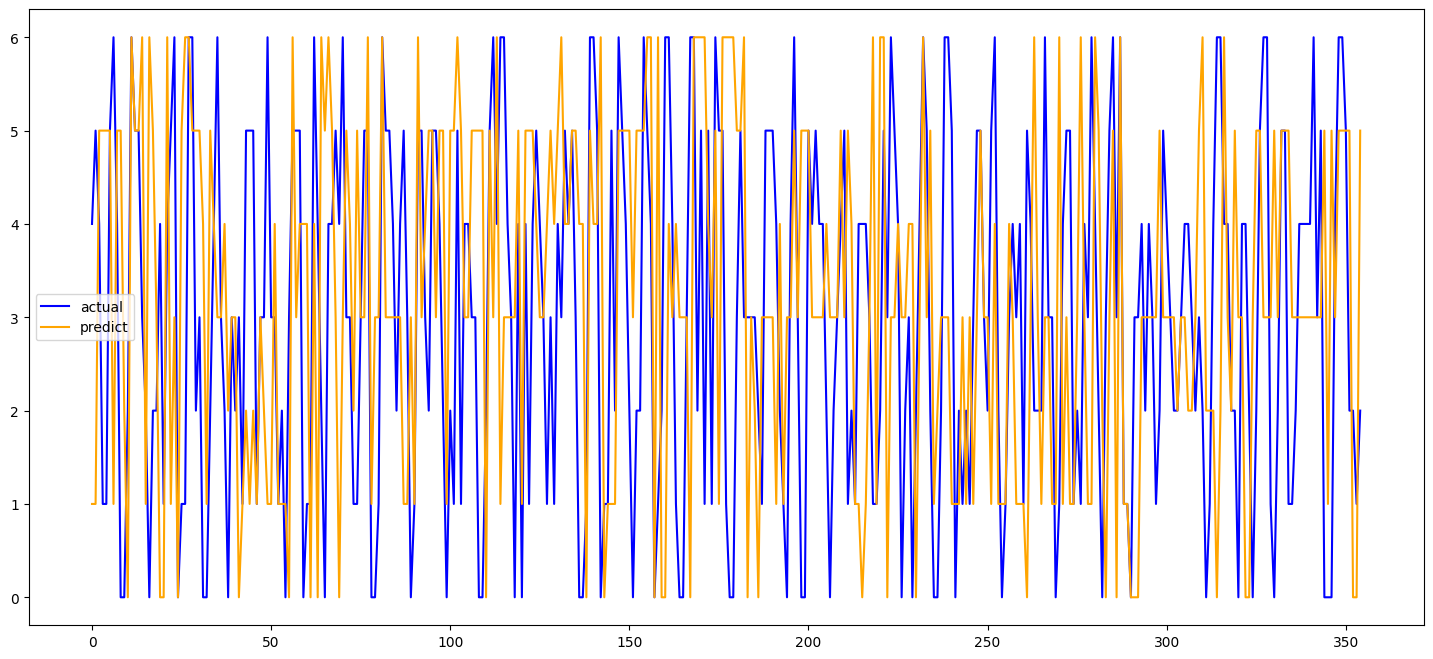

16.34%,1%
16.34%,2%
16.34%,3%
16.34%,4%
16.34%,5%
16.34%,6%
16.34%,7%
16.34%,8%
16.34%,9%
16.34%,10%
16.34%,11%
   - MAE : 2.15 (2.00 sur 2023)
   - MSE : 7.16 (6.36 sur 2023)
[2. 4. 6. 1. 1. 3. 6. 3. 3. 6. 3. 2. 0. 5. 3. 2. 6. 1. 6. 6. 5. 6. 5. 6.
 6. 6. 6. 1. 6. 3. 3. 5. 1. 5. 6. 6. 5. 5. 5. 2. 2. 5. 1. 5. 5. 1. 1. 1.
 6. 5. 1. 1. 1. 1. 5. 6. 5. 5. 5. 0. 4. 4. 4. 3. 4. 2. 4. 4. 0. 4. 6. 0.
 1. 1. 1. 1. 5. 5. 0. 5. 5. 0. 3. 5. 6. 0. 5. 1. 5. 5. 3. 3. 3. 2. 2. 0.
 0. 1. 4. 5. 5. 5. 0. 0. 5. 6. 5. 1. 5. 0. 3. 2. 3. 1. 5. 3. 3. 1. 4. 4.
 1. 1. 1. 1. 2. 5. 2. 1. 1. 1. 1. 0. 6. 6. 6. 5. 1. 1. 5. 1. 5. 5. 5. 2.
 1. 1. 1. 1. 4. 3. 1. 4. 4. 2. 6. 3. 4. 1. 4. 3. 3. 6. 3. 3. 4. 4. 5. 4.
 4. 5. 4. 1. 1. 1. 1. 6. 2. 4. 4. 1. 1. 6. 4. 5. 4. 1. 1. 1. 2. 6. 2. 2.
 1. 0. 2. 2. 2. 5. 2. 0. 2. 2. 2. 3. 4. 1. 3. 3. 3. 2. 6. 5. 5. 1. 2. 1.
 2. 5. 1. 1. 2. 3. 5. 6. 4. 1. 5. 2. 2. 1. 5. 5. 1. 5. 2. 1. 1. 5. 2. 2.
 1. 0. 2. 1. 1. 6. 3. 3. 0. 1. 3. 1. 1. 1. 3. 0. 1. 1. 1. 3. 3. 3. 3. 3.
 1. 1. 3. 3. 3. 0. 1.

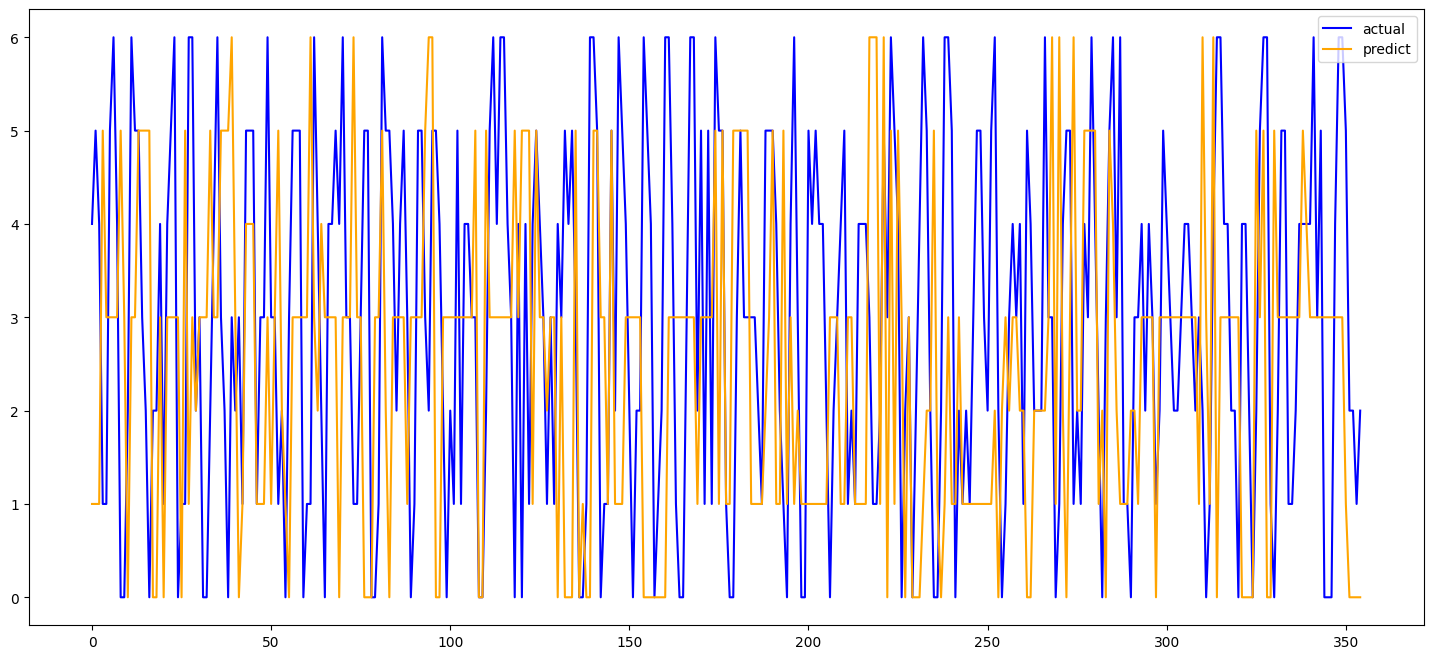

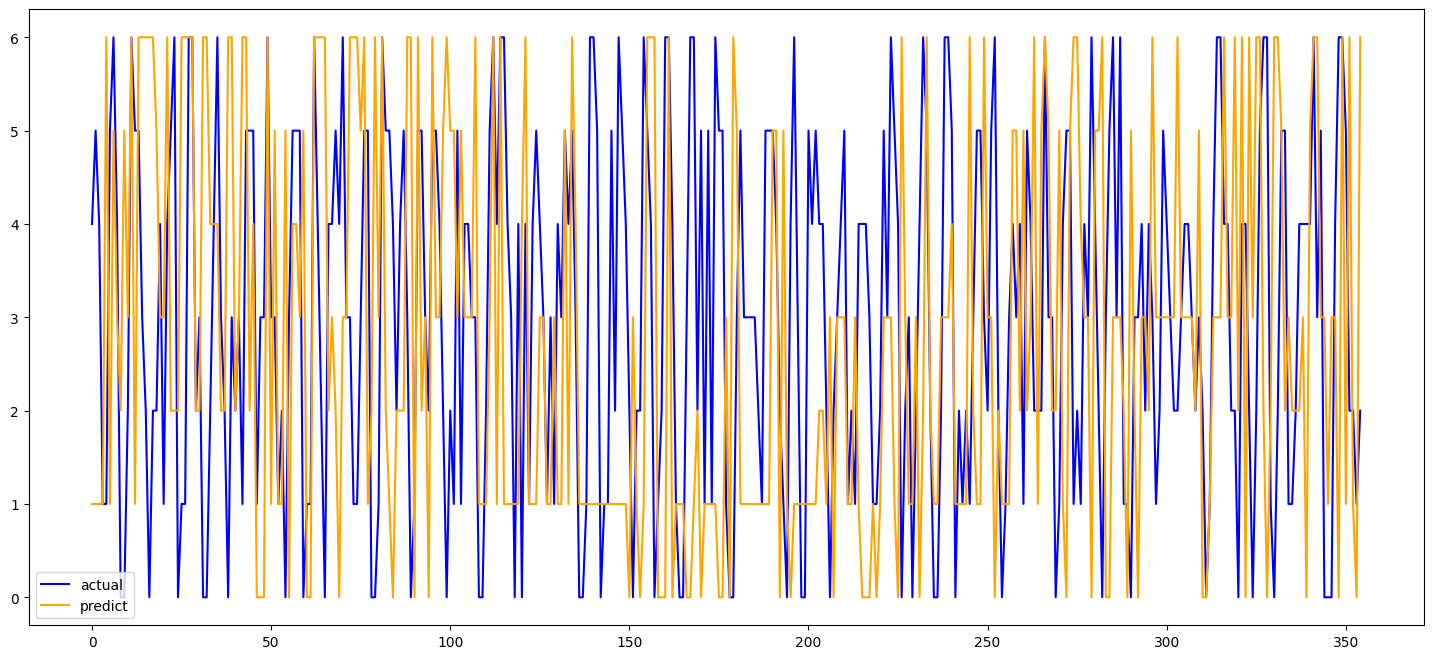

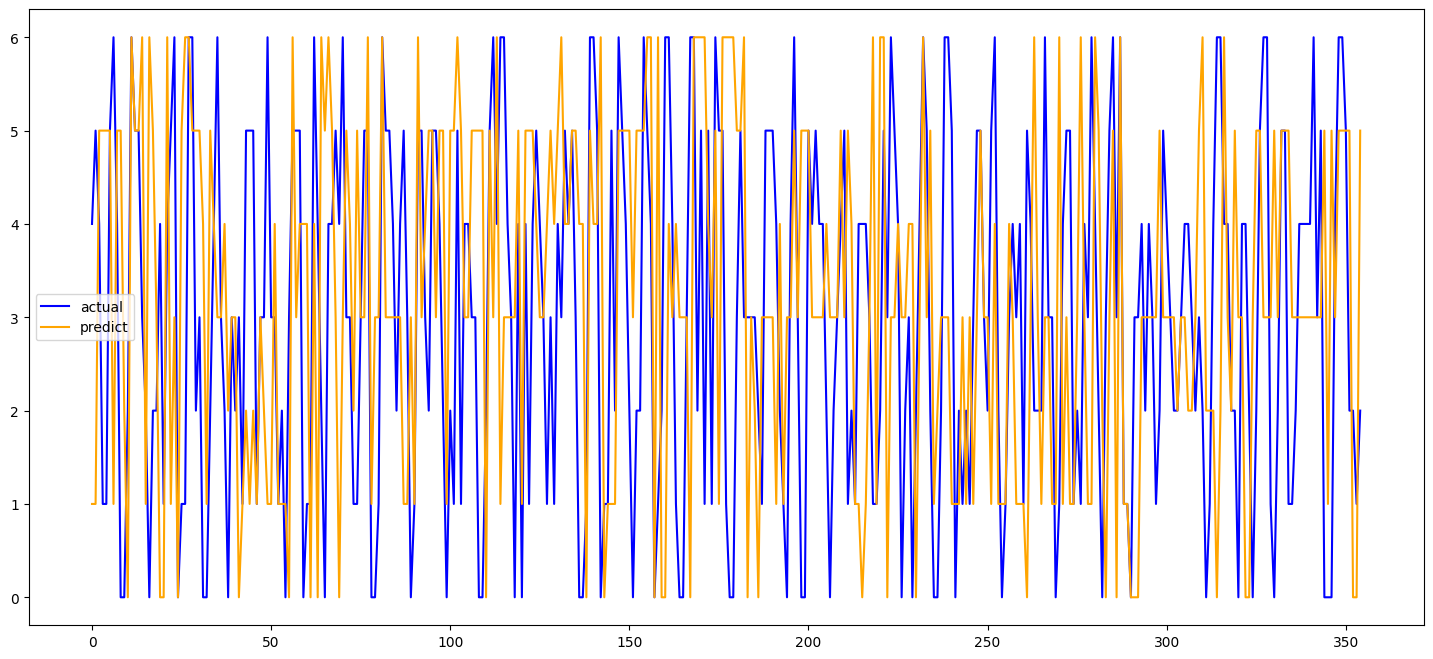

In [25]:
params = {'eta': 0.05, 
          'objective': 'multi:softmax', 
          'eval_metric': ['mlogloss', 'merror'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1,
          'device':'cuda',
          'num_class':8}

score = 100000
# cols = ['dayofYear', 'month']
# col = "holidays"
# new_score, _ = teste(df[cols+[col, 'target']], params, score=score)
new_score, reg = teste(df, params, score=score)

In [26]:
df0

,trend_fracture%%mean_7J,trend_vertiges%%J-1,meteo_wspd%%J-4,holidays%%J-2,trend_infection cutanée%%J-3,confinement1%%J-7,trend_vaccin%%mean_7J,trend_éruption cutanée%%J-5,trend_saignements%%J-1,trend_AVC,...,trend_mal de tête%%J-7,trend_saignements%%J-2,trend_noyade%%J-1,meteo_tavg%%J-7,trend_hopital%%J-6,trend_accident de voiture%%mean_7J,PM10_FR26005%%mean_7J,trend_vaccin%%J-2,trend_fièvre%%std_31J,nb_emmergencies%%std_31J
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,18.857143,0.0,0.0,18.612460
2019-01-04,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,17.714286,0.0,0.0,18.612460
2019-01-05,0.0,0.0,6.2,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.428571,0.0,0.0,18.612460
2019-01-06,0.0,0.0,17.4,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.571429,0.0,0.0,18.612460
2019-01-07,0.0,0.0,14.1,True,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.9,0.0,0.0,15.142857,0.0,0.0,18.612460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,0.0,0.0,10.2,False,0.0,False,1.285714,0.0,0.0,0.0,...,0.0,0.0,0.0,8.8,11.0,0.0,12.714286,0.0,0.0,17.007525
2023-12-21,0.0,0.0,5.0,False,75.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,7.4,18.0,0.0,13.428571,0.0,0.0,17.017006
2023-12-22,0.0,0.0,4.9,False,0.0,False,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,5.6,0.0,0.0,13.285714,0.0,0.0,16.470044


In [27]:
seasonal_decompose(arsTabularDataset.data.loc[arsTabularDataset.data.index.year == 2023, target], model='additive', period=7).resid

date
2023-01-01         NaN
2023-01-02         NaN
2023-01-03         NaN
2023-01-04   -1.458069
2023-01-05   -4.048171
                ...   
2023-12-20   -0.172354
2023-12-21   -1.238647
2023-12-22         NaN
2023-12-23         NaN
2023-12-24         NaN
Name: resid, Length: 358, dtype: float64

In [1]:
dg = df0.loc[df0.index.year == 2023][:-3]
dh = df.loc[df.index.year == 2023].drop(columns='target')
dg['pred'] = reg.predict(xgb.DMatrix(dh)).round(0)
resid = seasonal_decompose(arsTabularDataset.data.loc[arsTabularDataset.data.index.year == 2023, [target]], model='additive', period=7).resid
fig, ax = plt.subplots()

classes = categorize(resid.to_frame(), 'resid', bins=7, drop=False, offset=0)
calsses_values = classes.groupby('resid_category')['resid'].mean()
# calsses_values = calsses_values.astype(int)
dg['pred'] = [calsses_values[classe] for classe in dg['pred'].astype(int)]

dg.plot(y=['pred'], ax=ax)
resid.plot(ax=ax)
ax.legend(['pred', 'truth'])
ax.set(title='Residuals')
df['target'] = [calsses_values[classe] for classe in df['target'].astype(int)]
(df.loc[df.index.year == 2023, ['target']][:-3]).plot(ax=ax) # * 30 + dg[target].mean()/2
print(f"MAE: {mean_absolute_error(dg[target], dg['pred']):.2f}")

NameError: name 'df0' is not defined

In [35]:
calsses_values

resid_category
0   -8.637356
1   -4.422090
2   -1.972802
3   -0.023137
4    1.864610
5    4.307599
6    8.713435
Name: resid, dtype: float64

In [ ]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = reg.get_score(importance_type='gain')
importance_cover = reg.get_score(importance_type='cover')
importance_weight = reg.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

di['gain_norm'] = di['gain'] / di['gain'].sum()
di['cover_norm'] = di['cover'] / di['cover'].sum()
di['weight_norm'] = di['weight'] / di['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

di['importance'] = (di['gain_norm'] * w_gain) + (di['cover_norm'] * w_cover) + (di['weight_norm'] * w_weight)

di.sort_values(by='importance', ascending=False, inplace=True)
di['rank'] = di['importance'].rank(ascending=False)

di.reset_index(inplace=True)
di.rename(columns={'index': 'feature'}, inplace=True)
print(di[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])
